Top Ranked Strategies
---------------------

This manuscript uses a collection of 195 strategies. These strategies are evaluated in different enviroments based on their normalised rank.
Ranks vary between 0 and $N - 1$, where $N$ is the number of strategies in the tournament. The normalised rank, denote as $r$ is $\in [0, 1]$. The smaller the normalised rank the better the perfomance.

In [1]:
import pandas as pd
import dask.dataframe as dd

import imp

prepare_data = imp.load_source('prepare_data', '../src/prepare_data.py')
process_data = imp.load_source('processe_data', '../src/process_data.py')

In [2]:
import scipy.stats as stats

In [3]:
import seaborn as sns
import numpy as np
import matplotlib

In [4]:
import matplotlib.pyplot as plt

In [5]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

color = matplotlib.cm.viridis(0.3)
color_c = matplotlib.cm.viridis(0.4)

**Reading data sets**

In [6]:
dfs = []
for name in ['standard', 'noise', 'probend', 'probend_noise']:
    df = pd.read_csv('../data/%s_3_processed.csv' % name, index_col=0
                           )
    df['type'] = name
    dfs.append(df)

//anaconda3/envs/axlml/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


**Descriptive measures**

In [7]:
unique_number_of_seeds = len(dfs[0].seed.unique())
unique_number_of_seeds

11420

In [8]:
file = open('../paper/unique_number_of_seeds.tex', "w")
file.write("{}".format(unique_number_of_seeds))
file.close()

In [9]:
len(dfs[0]['Name'].unique())

195

In [10]:
file = open('../paper/unique_number_of_strategies.tex', "w")
file.write("{}".format(len(dfs[0]['Name'].unique())))
file.close()

In [11]:
number_of_all_tournaments = sum([len(df.seed.unique()) for df in dfs])

In [12]:
file = open('../paper/number_of_all_tournaments.tex', "w")
file.write("{}".format(number_of_all_tournaments))
file.close()

**$r$ example of Tit For Tat**

In [13]:
tournament_types = ['standard', 'noisy', 'probabilistic ending', 'noisy probabilistic ending']

//anaconda3/envs/axlml/lib/python3.6/site-packages/matplotlib/mathtext.py:2468: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


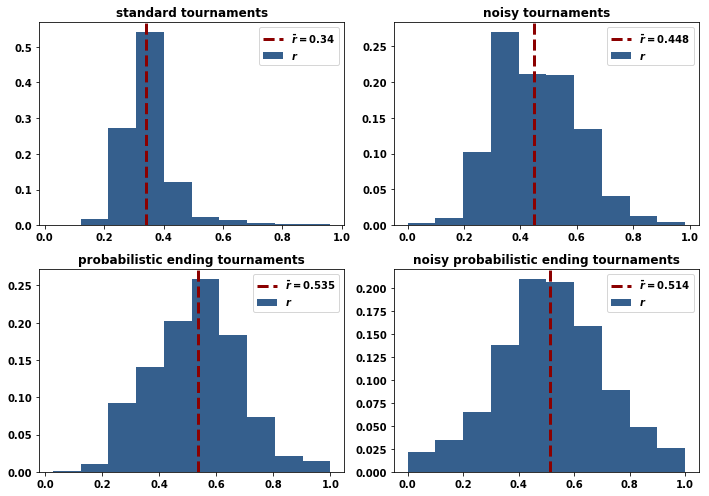

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

for i in range(4):
    index = (int(i / 2), i % 2)

    values = dfs[i][dfs[i]['Name'] == 'Tit For Tat']['Normalized_Rank'].unique()
    weights = np.ones_like(values) / float(len(values))
    axes[index].hist(values, weights=weights, color=color, label=r'$r$')
    axes[index].axvline(
        np.median(values),
        color="darkred",
        linestyle="dashed",
        linewidth=3,
        label=r"$\bar{r}=%s$" % round(np.median(values), 3),
    )
    axes[index]
    axes[index].set_title(r'%s tournaments' % tournament_types[i], fontweight="bold")
    axes[index].legend();
plt.tight_layout();
plt.savefig('../images/tit_for_tat_r_distributions.pdf', bbox_inches='tight')

**Top performances in six enviroments table**

In [15]:
average_prfs = []
for df in dfs:
    df_type = df['type'].unique()[0]
    average_prfs.append(df.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3))
    
    if df_type == 'noise':
        temp = df[df['noise'] < 0.10]
        average_prfs.append(temp.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3))
        
    if df_type == 'probend':
        temp = df[df['probend'] < 0.10]
        average_prfs.append(temp.groupby(['Name']).median()['Normalized_Rank'].round(decimals=3))

In [16]:
columns = []
for prfs in average_prfs:
    columns.append(prfs.sort_values()[:15].index)
    columns.append(prfs.sort_values()[:15].values)

In [17]:
table = pd.DataFrame.from_records(columns,).T

In [18]:
table.columns = ['Name', r'$\bar{r}$'] * 6

In [19]:
table.head()

,Name,$\bar{r}$,Name,$\bar{r}$,Name,$\bar{r}$,Name,$\bar{r}$,Name,$\bar{r}$,Name,$\bar{r}$
0,Evolved HMM 5,0.007,Grumpy,0.14,DBS,0,Fortress4,0.013,Evolved FSM 16,0,Alternator,0.304
1,Evolved FSM 16,0.01,$e$,0.194,Evolved FSM 16 Noise 05,0.008,Defector,0.014,Evolved FSM 16 Noise 05,0.013,$\phi$,0.31
2,EvolvedLookerUp2_2_2,0.011,Tit For 2 Tats,0.206,Evolved ANN 5 Noise 05,0.013,Better and Better,0.016,MEM2,0.027,$e$,0.312
3,Evolved FSM 16 Noise 05,0.017,Slow Tit For Two Tats,0.21,BackStabber,0.024,Tricky Defector,0.019,Evolved HMM 5,0.044,$\pi$,0.317
4,PSO Gambler 2_2_2,0.021,Cycle Hunter,0.215,DoubleCrosser,0.025,Fortress3,0.022,EvolvedLookerUp2_2_2,0.049,Limited Retaliate,0.353


In [20]:
file = open('../paper/perfomances_table.tex', "w")
file.write(table.to_latex())
file.close()

**Plot $r$ distributions of top performances in six enviroments**

In [21]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import gaussian_kde

%matplotlib inline

In [22]:
def get_distribution_without_outliers(distribution, percentage=0.1):
    distribution.sort()
    size_of_ditribution = len(distribution)
    outliers = int(size_of_ditribution * (percentage))
    
    return distribution[:-outliers]

**Top variation**

In [23]:
def plot_perfomance_violin_plots(type_index,
                                 tournament_type,
                                 top_names,
                                 ylim_up=1,
                                 remove_outliers=False,
                                 percentage=0.1):
    data, violin_data = [], []
    for name in top_names:
        distribution = dfs[type_index][dfs[type_index]['Name'] == name]['Normalized_Rank'].values
        
        data.append(distribution)
        
        if remove_outliers:
            distribution = get_distribution_without_outliers(distribution, percentage)
        violin_data.append(distribution)

    means = [np.mean(dt) for dt in data]

    fig, axes = plt.subplots(figsize=(10, 4))

    parts = axes.violinplot(violin_data, showextrema=False,
                            showmeans=False);

    boxes = axes.boxplot(data, showfliers=False)
    axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)

    for bp in boxes['medians']:
        bp.set_color('purple')
        bp.set_linewidth(2)
        bp.set_linestyle('-.')
    for bp in boxes['caps']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['whiskers']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['boxes']:
        bp.set_color('navy')
        bp.set_linewidth(2)

    axes.set_ylabel(r'$r$')
    axes.set_ylim([0, ylim_up]);
    axes.set_xticklabels(list(top_names), rotation=90);

    fig.savefig('../images/performance_%s.pdf' % tournament_type,
                bbox_inches='tight')

In [24]:
def plot_perfomance_violin_plots(df,
                                 top_names,
                                 axes,
                                 ylim_up=1,
                                 remove_outliers=False,
                                 percentage=0.1):
    data, violin_data = [], []
    for name in top_names:
        distribution = df[df['Name'] == name]['Normalized_Rank'].values
        
        data.append(distribution)
        
        if remove_outliers:
            distribution = get_distribution_without_outliers(distribution, percentage)
        violin_data.append(distribution)

    means = [np.mean(dt) for dt in data]

    parts = axes.violinplot(violin_data, showextrema=False,
                            showmeans=False);

    boxes = axes.boxplot(data, showfliers=False)
    axes.scatter(range(1, len(means) + 1), means, marker='o', color='purple', zorder=3, s=50)

    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)

    for bp in boxes['medians']:
        bp.set_color('purple')
        bp.set_linewidth(2)
        bp.set_linestyle('-.')
    for bp in boxes['caps']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['whiskers']:
        bp.set_color('navy')
        bp.set_linewidth(2)
    for bp in boxes['boxes']:
        bp.set_color('navy')
        bp.set_linewidth(2)

    axes.set_ylabel(r'$r$')
    axes.set_ylim([0, ylim_up]);
    axes.set_xticklabels(list(top_names), rotation=90);

**Top names**

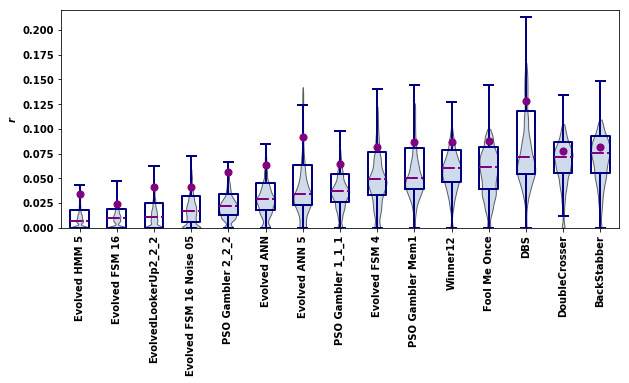

In [25]:
fig, axes = plt.subplots(figsize=(10, 4))

top_names = list(average_prfs[0].sort_values()[:15].index)
plot_perfomance_violin_plots(dfs[0],
                             top_names,
                             axes,
                             ylim_up=0.22,
                             remove_outliers=True,
                             percentage=0.15)

fig.savefig('../images/r_distribution_standard.pdf', bbox_inches='tight')

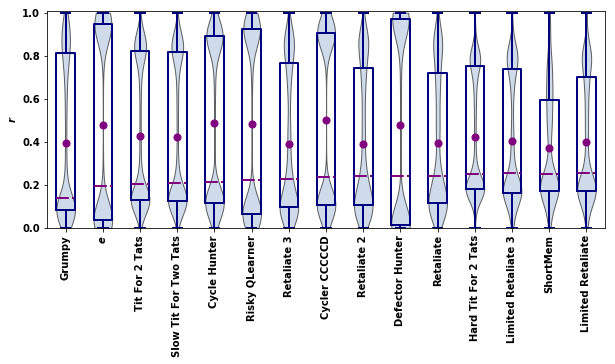

In [26]:
fig, axes = plt.subplots(figsize=(10, 4))

top_names_noise = list(average_prfs[1].sort_values()[:15].index)
plot_perfomance_violin_plots(dfs[1],
                             top_names_noise,
                             axes,
                             ylim_up=1.01)

fig.savefig('../images/r_distribution_noise.pdf', bbox_inches='tight')

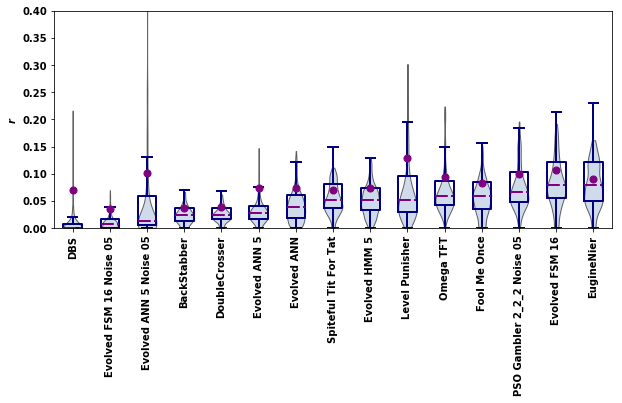

In [27]:
fig, axes = plt.subplots(figsize=(10, 4))

top_names_noise_subset = list(average_prfs[2].sort_values()[:15].index)

noise_subset = dfs[1][dfs[1]['noise'] < 0.10]

plot_perfomance_violin_plots(noise_subset,
                             top_names_noise_subset,
                             axes,
                             ylim_up=0.4,
                             remove_outliers=True,
                             percentage=0.1)

fig.savefig('../images/r_distribution_noise_subset.pdf', bbox_inches='tight')

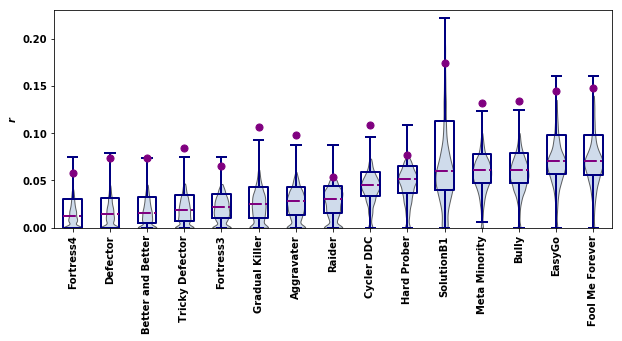

In [28]:
fig, axes = plt.subplots(figsize=(10, 4))

top_names_probend = list(average_prfs[3].sort_values()[:15].index)


plot_perfomance_violin_plots(dfs[2],
                             top_names_probend,
                             axes,
                             ylim_up=0.23,
                             remove_outliers=True,
                             percentage=0.17)

fig.savefig('../images/r_distribution_probend.pdf', bbox_inches='tight')

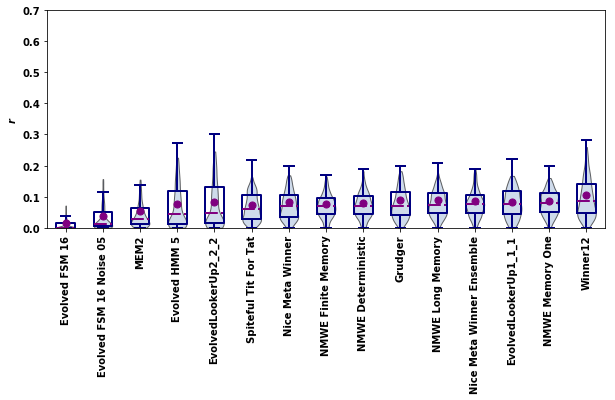

In [29]:
fig, axes = plt.subplots(figsize=(10, 4))

top_names_probend_subset = list(average_prfs[4].sort_values()[:15].index)

probend_subset = dfs[2][dfs[2]['probend'] < 0.10]

plot_perfomance_violin_plots(probend_subset,
                             top_names_probend_subset,
                             axes,
                             ylim_up=0.7,
                             remove_outliers=True,
                             percentage=0.05)

fig.savefig('../images/r_distribution_probend_subset.pdf', bbox_inches='tight')

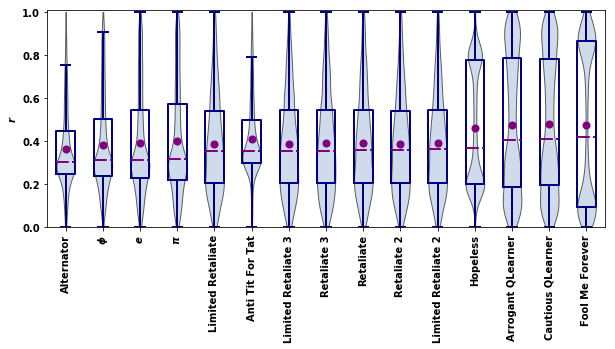

In [30]:
fig, axes = plt.subplots(figsize=(10, 4))

top_names_mixed = list(average_prfs[-1].sort_values()[:15].index)


plot_perfomance_violin_plots(dfs[3],
                             top_names_mixed,
                             axes,
                             ylim_up=1.01)

fig.savefig('../images/r_distribution_probend_noise.pdf', bbox_inches='tight')

**Merged Performance Table**

In [31]:
dfs_j_rank = [df[['Normalized_Rank', 'Name']] for df in dfs]

In [32]:
ranks = pd.concat(dfs_j_rank).groupby(['Name']).median()['Normalized_Rank'].round(3)

In [33]:
top_names_overall = list(ranks.sort_values()[:15].index)

In [34]:
top_names_mixed = list(average_prfs[3].sort_values()[:15].index)

In [35]:
file = open('../paper/performance_merged_table.tex', "w")
file.write(ranks.sort_values()[:15].to_latex())
file.close()

**Folk Theorem**

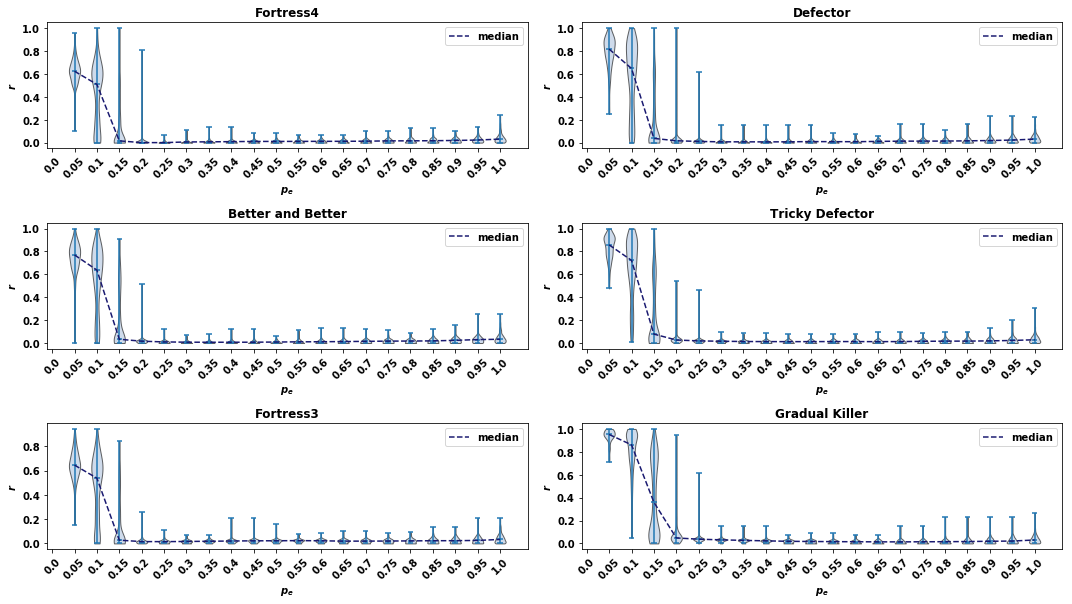

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8.5))

probend_val = np.linspace(0, 1, 21)
probend_val = [round(val, 2) for val in probend_val]
for i, name in enumerate(top_names_probend[:6]):
    temp = dfs[2][dfs[2]['Name'] == name][['probend', 'Normalized_Rank']]
    index = (int(i / 2), i % 2)
    
    distributions = []
    for j, val in enumerate(probend_val[1:]):
        if j !=0:
            distributions.append(temp[(temp['probend'] <= val) & (temp['probend'] > probend_val[j-1])]['Normalized_Rank'])
        else:
            distributions.append(temp[(temp['probend'] <= val)]['Normalized_Rank'])
    
    violin_data = [distribution.values for distribution in distributions]
    medians = [np.nan] + [np.median(distribution) for distribution in distributions]
    axes[index].plot(medians, color='midnightblue', linestyle='--', label='median')
    parts = axes[index].violinplot(violin_data, showmedians=True);
    axes[index].set_title(name, fontweight='bold')
    axes[index].set_ylabel('$r$')
    axes[index].set_xlabel('$p_e$')
    axes[index].set_xlabel('$p_e$')

    axes[index].set_xticks(range(len(probend_val)))
    axes[index].set_xticklabels(probend_val, rotation=45)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)
    axes[index].legend()
        
fig.tight_layout()
plt.savefig('../images/folk_theorem.pdf', bbox_inches='tight')

In [37]:
probend = dfs[2][dfs[2]['probend'] < 0.10]

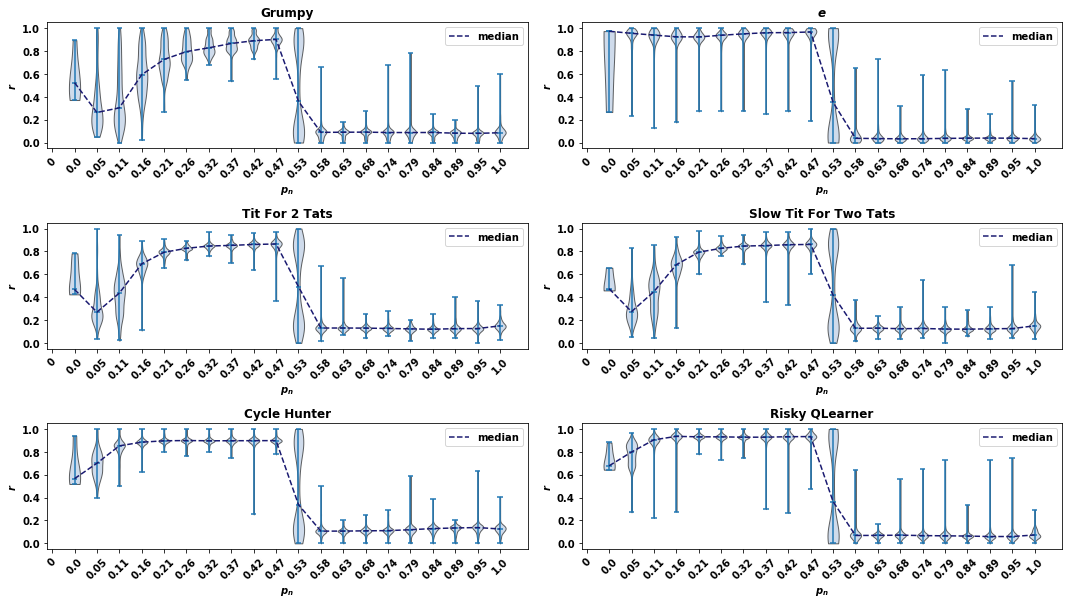

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8.5))
noise_val = np.linspace(0, 1, 20)
noise_val = [round(val, 2) for val in noise_val]
for i, name in enumerate(top_names_noise[:6]):
    temp = dfs[1][dfs[1]['Name'] == name][['noise', 'Normalized_Rank']].round({'noise': 3})
    index = (int(i / 2), i % 2)
    
    distributions = []
    for j, val in enumerate(noise_val):
        if j !=0:
            distributions.append(temp[(temp['noise'] <= val) & (temp['noise'] > noise_val[j-1])]['Normalized_Rank'])
        else:
            distributions.append(temp[(temp['noise'] <= val)]['Normalized_Rank'])
    
    violin_data = [distribution.values for distribution in distributions]
    parts = axes[index].violinplot(violin_data, showmedians=True);
    medians = [np.nan] + [np.median(distribution) for distribution in distributions]
    axes[index].plot(medians, color='midnightblue', linestyle='--', label='median')
    axes[index].set_title(name, fontweight='bold')
    axes[index].set_ylabel('$r$')
    axes[index].set_xlabel('$p_n$')
    axes[index].set_xticks(range(21))
    axes[index].set_xticklabels([0] + noise_val, rotation=45)
    
    for pc in parts['bodies']:
        pc.set_facecolor('lightsteelblue')
        pc.set_edgecolor('black')
        pc.set_alpha(.60)
    axes[index].legend();
fig.tight_layout()

plt.savefig('../images/noise_effect.pdf', bbox_inches='tight')